In [7]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
data = pd.read_csv('data.csv')
data = data.drop(columns=['Unnamed: 0.1','Unnamed: 0'],axis=1)

path_df = pd.read_csv('detailed_paths_history.csv')
# Clean column names by removing leading/trailing whitespace
path_df.columns = path_df.columns.str.strip()
# Clean values by removing leading/trailing whitespace
path_df['start_ship'] = path_df['start_ship'].str.strip()
path_df['end_ship'] = path_df['end_ship'].str.strip()

In [8]:
colonnes_qualitatives=[]
colonnes_quantitatives=[]
for col in data.columns : 
    try:
        pd.to_numeric(data[col])
        #colonnes_quantitatives.append(str(col))
    except :
        colonnes_qualitatives.append(col)
for col in data.columns :
    if col not in colonnes_qualitatives:
        colonnes_quantitatives.append(col)

In [9]:
import random

def choisir_mot():
    return random.choice(list(data['name']))

def aide_a_trouver_nom_vaisseau(nom_partiel):
    res=[]
    for nom in list(data['name']):
        if len(nom_partiel)<=len(nom):
            compatible=True
            for k in range(len(nom_partiel)):
                if nom_partiel[k]!=nom[k]:
                    compatible=False
            if compatible : 
                res.append(nom)
    return res

def verifier_ship(ship_secret, ship_guess):
    
    # Vérifie si la tentative existe dans le DataFrame
    if not ship_guess in list(data['name']):
        return "Ce vaisseau n'existe pas dans la base de données!"

    # Indique quand c'est la bonne réponse
    if ship_guess==ship_secret :
        return 'Bravo, vous avez trouvez le bon vaisseau!'

    L=list(data['name'])
    k = L.index(ship_guess)
    a = L.index(ship_secret)
    res=f"Ce n'est pas {ship_guess} Voici les résultats de chaque variables :"
    
    for col in data.columns : 
        if not col in ['Unnamed: 0','name']:
            res+='\n '
            res+='-pour la variable '
            res+=col
            res+=' '
            if col in colonnes_qualitatives :
                if data[col][k]!=data[col][a]:
                    res+="Ce n'est pas la bonne réponse"
                else:
                    res+="C'est la bonne réponse✅"
                    
            if col in colonnes_quantitatives : 
                if data[col][a]<data[col][k]:
                    res += f"La valeur de {col} est supérieure"
                elif data[col][a]> data[col][k]:
                    res += f"La valeur de {col} est inférieure"
                else:
                    res += "C'est la bonne réponse "
    print(res)
    return 0   

def stardle():
    
    print("Liste des vaisseaux disponibles:")
    for idx, name in enumerate(data['name']):
        print(f"{idx + 1}. {name}")
        
    ship_secret = choisir_mot()
    tentatives = 6
    print("Bienvenue dans Stardle! Devine le vaisseau")
    
    for _ in range(tentatives):
        
        tentative = input("Entrez votre tentative: ")
            
        # Vérifie si le mot existe
        resultat = verifier_ship(ship_secret,ship_guess=tentative)
        if resultat == "Ce vaisseau n'existe pas dans la base de données!":
            print(resultat)
            continue
            
        print(resultat)
        
        #if all(car == "✅" for car in resultat if car in ["✅", "🟡", "❌"]):
        if resultat!=0:
            print(f"Félicitations! Vous avez trouvé le vaisseau! Le vaisseau était: {ship_secret}")
            break
    else:
        print(f"Désolé, vous avez épuisé vos tentatives. Le vaisseau était: {ship_secret}")

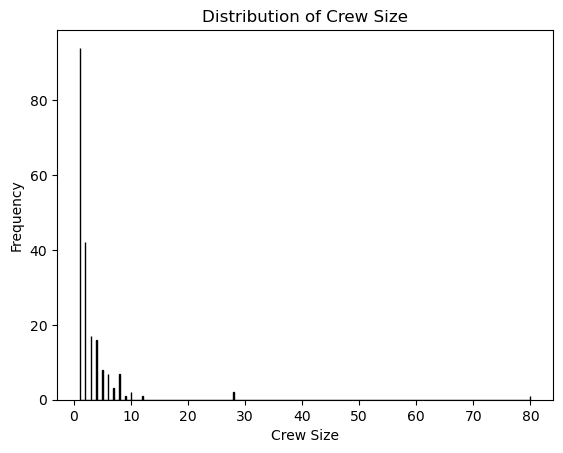

In [10]:
import matplotlib.pyplot as plt

plt.hist(data['crew'], bins=1000, edgecolor='black')
plt.title('Distribution of Crew Size')
plt.xlabel('Crew Size')
plt.ylabel('Frequency')
plt.show()

In [11]:
class ShipTreeNode:
    def __init__(self, ship_data):
        self.ship_data = ship_data
        self.left = None
        self.right = None
        self.name = ship_data['name']
        self.crew = ship_data['crew']
        self.manufacturer = ship_data['manufacturer']
        self.role = ship_data['role']
        self.type = ship_data['type']
        self.status = ship_data['status']
        self.year = ship_data['release_date']

class ShipSearchTree:
    def __init__(self):
        self.root = None
        self.ship_nodes = {}
        self.distances_cache = {}
        self.paths_cache = {}
        self.path_usage = {}  
        self.paths_history = []  # Nouveau: historique des chemins parcourus

        
    def insert(self, ship_data):
        node = ShipTreeNode(ship_data)
        self.ship_nodes[ship_data['name']] = node
        
        if self.root is None:
            self.root = node
        else:
            self._insert_recursive(self.root, node)
            
    def _insert_recursive(self, current, node):
        if node.crew < current.crew:
            if current.left is None:
                current.left = node
            else:
                self._insert_recursive(current.left, node)
        else:
            if current.right is None:
                current.right = node
            else:
                self._insert_recursive(current.right, node)

    def calculate_distance(self, ship1_name, ship2_name):
        # Récupérer les noeuds des vaisseaux
        ship1 = self.ship_nodes[ship1_name]
        ship2 = self.ship_nodes[ship2_name]
        
        distance = 0
        
        # Distance basée sur l'équipage (normalisée)
        crew_diff = abs(ship1.crew - ship2.crew) / max(1, max(ship1.crew, ship2.crew))
        distance += crew_diff * 2
        
        # Pénalités pour les différences
        if ship1.manufacturer != ship2.manufacturer:
            distance += 1.0
        if ship1.type != ship2.type:
            distance += 1.0
        if ship1.role != ship2.role:
            distance += 1.0
        if ship1.status != ship2.status:
            distance += 1.0
        if ship1.crew != ship2.crew:
            distance += 1.0
        if ship1.year != ship2.year:
            distance += 1.0

        return np.sqrt(distance)

    def find_shortest_path(self, start_name, end_name):
        import heapq
        
        # Initialisation
        distances = {ship: float('inf') for ship in self.ship_nodes}
        distances[start_name] = 0
        pq = [(0, start_name, [start_name])]
        visited = set()
        
        while pq:
            current_distance, current_ship, path = heapq.heappop(pq)
            
            if current_ship == end_name:
                return path, current_distance
                
            if current_ship in visited:
                continue
                
            visited.add(current_ship)
            
            # Explorer les voisins
            for next_ship in self.ship_nodes:
                if next_ship not in visited:
                    distance = self.calculate_distance(current_ship, next_ship)
                    new_distance = current_distance + distance
                    
                    if new_distance < distances[next_ship]:
                        distances[next_ship] = new_distance
                        new_path = path + [next_ship]
                        heapq.heappush(pq, (new_distance, next_ship, new_path))
        
        return None, None

    def record_path_usage(self, path):
        """Enregistre l'utilisation des nœuds dans un chemin"""
        for i in range(len(path)-1):
            node1 = path[i]
            node2 = path[i+1]
            edge = tuple(sorted([node1, node2]))
            
            if edge not in self.path_usage:
                self.path_usage[edge] = 0
            self.path_usage[edge] += 1

    def save_path_history(self, path, total_distance):
        """Sauvegarde l'historique d'un chemin parcouru"""
        path_info = {
        'path': path,
        'distance': total_distance,
        'details': []
    }
    
        for i in range(len(path)):
            node = self.ship_nodes[path[i]]
            node_info = {
            'name': node.name,
            'manufacturer': node.manufacturer,
            'crew': node.crew,
            'role': node.role,
            'type': node.type,
            'status': node.status
            }
        
            if i < len(path) - 1:
                next_node = self.ship_nodes[path[i + 1]]
                distance = self.calculate_distance(node.name, next_node.name)
                node_info['distance_to_next'] = distance
        
            path_info['details'].append(node_info)
        
        self.paths_history.append(path_info)
        
        
# Utilisation :
def search_path(start_idx,end_idx):
    ship_tree = ShipSearchTree()
    
    # Insérer tous les vaisseaux
    for _, row in data.iterrows():
        ship_tree.insert(row)
        
    ships = list(data['name'].values)

    # Demander les vaisseaux de départ et d'arrivée
    path, total_distance = ship_tree.find_shortest_path(ships[start_idx], ships[end_idx])
    
    if path:
        print(f"\nChemin le plus court trouvé (distance totale: {total_distance:.2f}):")
        for i in range(len(path)):
            node = ship_tree.ship_nodes[path[i]]
            print(f"\n{node.name}:")
            
            if i < len(path) - 1:
                next_node = ship_tree.ship_nodes[path[i + 1]]
                dist = ship_tree.calculate_distance(node.name, next_node.name)
    else:
        print("\nAucun chemin trouvé entre ces vaisseaux.")
    
    return dist

def show_ship_paths():
    ship_tree = ShipSearchTree()
    for _, row in data.iterrows():
        ship_tree.insert(row)
    
    ships = list(ship_tree.ship_nodes.keys())
    all_paths = []  # Pour stocker tous les chemins

    for idx in range(len(ships)):
        for jdx in range(len(ships)):
            start_ship = data['name'][idx]
            end_ship = data['name'][jdx]
            
            nodes_path, total_distance = ship_tree.find_shortest_path(start_ship, end_ship)
            
            if nodes_path:
                # Enregistrer l'utilisation du chemin
                ship_tree.record_path_usage(nodes_path)
                # Sauvegarder l'historique du chemin
                ship_tree.save_path_history(nodes_path, total_distance)
                
                # Créer un dictionnaire avec les informations du chemin
                path_info = {
                    'start_ship': start_ship,
                    'end_ship': end_ship,
                    'path_length': len(nodes_path),
                    'total_distance': total_distance,
                    'complete_path': ' -> '.join(nodes_path)
                }
                all_paths.append(path_info)
                
                print(f"\nChemin de {start_ship} vers {end_ship} (distance: {total_distance:.2f}):")
                for i, node_name in enumerate(nodes_path):
                    node = ship_tree.ship_nodes[node_name]
                    print(f"\n{node.name}")
                    
                    if i < len(nodes_path) - 1:
                        next_node_name = nodes_path[i + 1]
                        next_node = ship_tree.ship_nodes[next_node_name]
                        dist = ship_tree.calculate_distance(node.name, next_node.name)
    
    # Sauvegarder l'historique dans un fichier CSV avec plus d'informations
    paths_df = pd.DataFrame(all_paths)
    paths_df.to_csv('detailed_paths_history.csv', index=False)
    print("\nHistorique détaillé des chemins sauvegardé dans 'detailed_paths_history.csv'")

In [12]:
def get_ship_distance(ship1, ship2):
    """
    Returns the distance between two ships from path_df
    
    Args:
        ship1 (str): Name of the first ship
        ship2 (str): Name of the second ship
        
    Returns:
        float: Distance between the ships, or None if not found
    """
    # Look up the distance in path_df
    result = path_df[(path_df['start_ship'] == ship1) & (path_df['end_ship'] == ship2)]
    
    if not result.empty:
        return result['total_distance'].values[0]
    else:
        # Check reverse direction if not found
        result = path_df[(path_df['start_ship'] == ship2) & (path_df['end_ship'] == ship1)]
        if not result.empty:
            return result['total_distance'].values[0]
        return None

In [13]:
def stardle_auto():
    """
    Version automatique de Stardle qui choisit intelligemment le prochain vaisseau
    en réduisant progressivement la distance au vaisseau mystère.
    
    Returns:
        tuple: (nombre de tentatives, liste des vaisseaux essayés)
    """
    
    ship_secret = choisir_mot()
    tentatives = 6
    visited_ships = []  # Changed from set to list to preserve order
    
    # Initialiser avec un vaisseau aléatoire
    current_ship = random.choice(list(data['name']))
    
    print("Stardle Auto - Recherche intelligente du vaisseau mystère")
    print(f"Démarrage avec le vaisseau: {current_ship}")
    
    for attempt in range(tentatives):
        print(f"\nTentative {attempt + 1}/{tentatives}")
        
        # Marquer le vaisseau comme visité
        visited_ships.append(current_ship)  # Append instead of add
        
        # Vérifier le vaisseau actuel
        resultat = verifier_ship(ship_secret, current_ship)
        if resultat == 'Bravo, vous avez trouvez le bon vaisseau!':
            print(f"\nVaisseau trouvé en {attempt + 1} tentatives!")
            return attempt + 1, visited_ships
            
        # Trouver les vaisseaux les plus proches non visités
        closest_ships = []
        idx_secret = data[data['name'] == ship_secret].index[0]
        
        for ship in data['name']:
            if ship not in visited_ships:
                idx_ship = data[data['name'] == ship].index[0]
                distance = get_ship_distance(ship, ship_secret)
                if distance is not None:  # Only add ships with valid distances
                    closest_ships.append((ship, distance))
        
        # Trier par distance et choisir le plus proche
        if closest_ships:
            closest_ships.sort(key=lambda x: x[1])
            current_ship = closest_ships[0][0]
            print(f"Prochain essai: {current_ship}")
        else:
            # Si aucun vaisseau valide n'est trouvé, choisir aléatoirement parmi les non visités
            available_ships = [ship for ship in data['name'] if ship not in visited_ships]
            if available_ships:
                current_ship = random.choice(available_ships)
                print(f"Prochain essai (aléatoire): {current_ship}")
            else:
                print("Plus de vaisseaux disponibles à essayer!")
                break
    
    print(f"\nÉchec - Le vaisseau mystère était: {ship_secret}")
    return tentatives + 1, visited_ships

# Example usage:
nb_tentatives, ships_used = stardle_auto()
print(f"\nNombre de tentatives: {nb_tentatives}")
print("Vaisseaux utilisés:")
for i, ship in enumerate(ships_used, 1):
    print(f"{i}. {ship}")

Stardle Auto - Recherche intelligente du vaisseau mystère
Démarrage avec le vaisseau: 125a

Tentative 1/6
Ce n'est pas 125a Voici les résultats de chaque variables :
 -pour la variable Unnamed: 1 Ce n'est pas la bonne réponse
 -pour la variable cargo_capacity La valeur de cargo_capacity est inférieure
 -pour la variable mass La valeur de mass est inférieure
 -pour la variable crew La valeur de crew est inférieure
 -pour la variable manufacturer Ce n'est pas la bonne réponse
 -pour la variable type Ce n'est pas la bonne réponse
 -pour la variable status C'est la bonne réponse✅
 -pour la variable role Ce n'est pas la bonne réponse
 -pour la variable price La valeur de price est inférieure
 -pour la variable release_date Ce n'est pas la bonne réponse
 -pour la variable price_ingame La valeur de price_ingame est inférieure
 -pour la variable scm La valeur de scm est supérieure
 -pour la variable max La valeur de max est supérieure
 -pour la variable length La valeur de length est inférieur

In [14]:
def run_multiple_stardle_auto(n_iterations):
    """
    Execute stardle_auto n times and collect statistics
    
    Returns:
        DataFrame: Contains results of all iterations
    """
    import pandas as pd
    
    # Lists to store results
    all_results = []
    
    for i in range(n_iterations):
        print(f"\nItération {i+1}/{n_iterations}")
        print("-" * 50)
        
        # Run stardle_auto
        nb_attempts, ships = stardle_auto()
        
        # Store results
        result = {
            'iteration': i+1,
            'nb_attempts': nb_attempts,
            'ships_used': ships,
            'secret_ship': ships[-1] if ships else None,  # Last ship is the secret one
            'path': ' -> '.join(ships)
        }
        all_results.append(result)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(all_results)
    
    # Save results to CSV
    results_df.to_csv('stardle_auto_results.csv', index=False)
    
    # Print summary statistics
    print("\nRésultats finaux:")
    print(f"Nombre moyen de tentatives: {results_df['nb_attempts'].mean():.2f}")
    print(f"Minimum de tentatives: {results_df['nb_attempts'].min()}")
    print(f"Maximum de tentatives: {results_df['nb_attempts'].max()}")
    
    return results_df

# Run the analysis
results = run_multiple_stardle_auto(500)
print("\nRésultats détaillés:")
print(results[['iteration', 'nb_attempts', 'path']])


Itération 1/500
--------------------------------------------------
Stardle Auto - Recherche intelligente du vaisseau mystère
Démarrage avec le vaisseau: Vulture

Tentative 1/6
Ce n'est pas Vulture Voici les résultats de chaque variables :
 -pour la variable Unnamed: 1 Ce n'est pas la bonne réponse
 -pour la variable cargo_capacity La valeur de cargo_capacity est supérieure
 -pour la variable mass La valeur de mass est supérieure
 -pour la variable crew C'est la bonne réponse 
 -pour la variable manufacturer Ce n'est pas la bonne réponse
 -pour la variable type Ce n'est pas la bonne réponse
 -pour la variable status C'est la bonne réponse✅
 -pour la variable role Ce n'est pas la bonne réponse
 -pour la variable price La valeur de price est supérieure
 -pour la variable release_date Ce n'est pas la bonne réponse
 -pour la variable price_ingame La valeur de price_ingame est supérieure
 -pour la variable scm La valeur de scm est inférieure
 -pour la variable max La valeur de max est infér

In [15]:
# Use the results DataFrame that's already defined
results = pd.read_csv('stardle_auto_results.csv', engine='python', quotechar='"', escapechar='\\')
attempts = results['nb_attempts']

In [16]:
results[results['nb_attempts']==7]

,iteration,nb_attempts,ships_used,secret_ship,path
369,370,7,"['Cutter Rambler', 'Vanguard Warden', 'Zeus ES...",Arrastra,Cutter Rambler -> Vanguard Warden -> Zeus ES M...


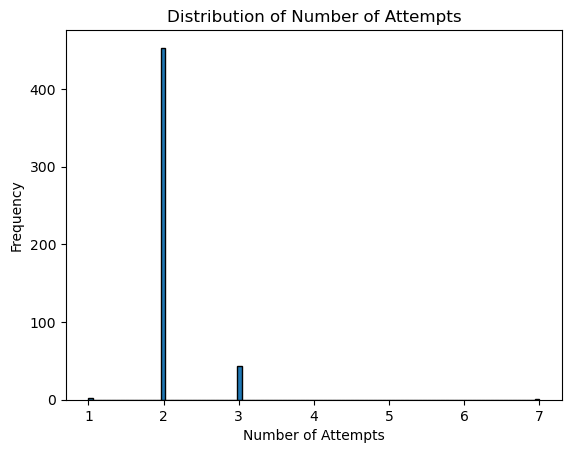

In [17]:
import matplotlib.pyplot as plt

plt.hist(attempts, bins=100, edgecolor='black')
plt.title('Distribution of Number of Attempts')
plt.xlabel('Number of Attempts')
plt.ylabel('Frequency')
plt.show()